## Federated learning using Keras (averaging weights)

**Status:** PUBLIC Distribution <br>
**File Name:** 02_Federated_learning_MNIST.ipynb

**Author:** Jaume Manero  <br> 
**Date created:** 2023/02/23<br>
**Last modified:** 2023/08/23<br>
**Description:** A simple federated learning program

see package requirements at the end of notebook <br>
Based on https://github.com/SadmanSakib93/Federated-Learning-Keras/blob/main/Fed%20Learning%20-%20FL.ipynb

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from tensorflow import keras
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from keras.utils import np_utils
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Convolution2D, Conv1D
from tensorflow.keras.layers import MaxPooling2D, MaxPooling1D
from keras import backend as K
from keras.datasets import mnist
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import time
import os
import psutil
import csv
from itertools import repeat
from PIL import Image
#from numpy import asarray

2023-08-27 04:47:54.761490: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-08-27 04:47:54.761508: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# We load the standard dataset and we convert it to 0..1
(xTrain, yTrain), (xTest, yTest) = mnist.load_data()

xTrain = xTrain.reshape(60000, 784)
xTest = xTest.reshape(10000, 784)
xTrain = xTrain.astype('float32')
x_test = xTest.astype('float32')
xTrain /= 255
x_test /= 255
print(xTrain.shape[0], 'train samples')
print(xTest.shape[0], 'test samples')

# convert class vectors to binary class matrices
yTrain = to_categorical(yTrain, 10)
yTest = to_categorical(yTest, 10)

60000 train samples
10000 test samples


In [3]:
# Global parameters

verb, epochs, batch_size = 0, 20, 64
numOfIterations = 25
numOfClients  = 5 # do not increase number of clients too much
modelLocation = "./Models/ANN_Sync_users_"+str(numOfClients)+str(numOfIterations)+"_FL_Model.h5"
accList, precList, recallList, f1List = [], [], [], []

In [4]:
# Server-Clients split 
# Train 30% of the data centrally and 70% in clients
xServer, xClients, yServer, yClients = train_test_split(xTrain, yTrain, test_size=0.90,random_state=523) 
xServerTest, xClientsTest, yServerTest, yClientsTest = train_test_split(xTrain, yTrain, 
                                                                        test_size=0.90,random_state=523)
print(xServer.shape, xClients.shape)

(6000, 784) (54000, 784)


In [5]:
def createDeepModel():
   model = Sequential()
   model.add(Dense(16, activation='relu', input_shape=(784,)))
   model.add(Dense(64, activation='relu'))
#   model.add(Dense(64, activation='relu'))
   model.add(Dense(10, activation='softmax'))
   model.summary()
   model.compile(loss='categorical_crossentropy',optimizer=RMSprop(),
              metrics=['accuracy'])
   return model

def predictTestData(yPredict, yTest):
    #Converting predictions to label
    print("yPredict",len(yPredict))
    pred = list()
    for i in range(len(yPredict)):
        pred.append(np.argmax(yPredict[i]))
    #Converting one hot encoded test label to label
    test = list()
    for i in range(len(yTest)):
        test.append(np.argmax(yTest[i]))
    return my_metrics(test, pred)

def sumOfWeights(weights):
    return sum(map(sum, weights))

def getWeights(model):
    allLayersWeights=deepModel.get_weights()
    return allLayersWeights

def my_metrics(y_true, y_pred):
    accuracy=accuracy_score(y_true, y_pred)
    precision=precision_score(y_true, y_pred,average='weighted')
    recall=recall_score(y_true, y_pred,average='weighted')
    f1Score=f1_score(y_true, y_pred, average='weighted') 
    print("Accuracy  : {}".format(accuracy))
    print("Precision : {}".format(precision))
    print("Recall : {}".format(recall))
    print("f1Score : {}".format(f1Score))
    cm=confusion_matrix(y_true, y_pred)
    print(cm)
    return accuracy, precision, recall, f1Score

In [6]:
# Analysis of accuracy and loss in training phase
def Analyze_training(h):
   f = plt.figure(figsize=(7, 3))
# summarize history for accuracy
# history.history.keys() -> dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
   plt.subplot(1,2,1)
   plt.plot(h.history['accuracy'])
   plt.plot(h.history['val_accuracy'])
   plt.title('model accuracy')
   plt.ylabel('accuracy')
   plt.xlabel('epoch')
   plt.legend(['train', 'test'], loc='upper left')
# summarize history for loss
   plt.subplot(1,2,2)
   plt.plot(h.history['loss'])
   plt.plot(h.history['val_loss'])
   plt.title('model loss')
   plt.ylabel('loss')
   plt.xlabel('epoch')
   plt.legend(['train', 'test'], loc='upper left')
   plt.show()
   return

In [7]:
# Supporting functions
deepModelAggWeights=[]
firstClientFlag=True

def updateServerModel(clientModel, clientModelWeight):
    global firstClientFlag
    for ind in range(len(clientModelWeight)):
        if(firstClientFlag==True):
            deepModelAggWeights.append(clientModelWeight[ind])            
        else:
            deepModelAggWeights[ind]=(deepModelAggWeights[ind]+clientModelWeight[ind])

def updateClientsModels():
    global clientsModelList
    global deepModel
    clientsModelList.clear()
    for clientID in range(numOfClients):
        m = keras.models.clone_model(deepModel)
        m.set_weights(deepModel.get_weights())
        clientsModelList.append(m)
    


In [8]:
# Initially train central deep model
nonFmodel = createDeepModel()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                12560     
                                                                 
 dense_1 (Dense)             (None, 64)                1088      
                                                                 
 dense_2 (Dense)             (None, 10)                650       
                                                                 
Total params: 14,298
Trainable params: 14,298
Non-trainable params: 0
_________________________________________________________________


2023-08-27 04:47:56.505845: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-27 04:47:56.506699: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-08-27 04:47:56.506760: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-08-27 04:47:56.506816: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-08-27 04:47:56.506872: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

### A. Centralized Model

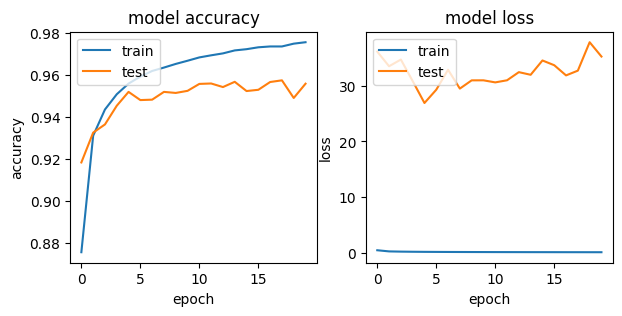

Accuracy  : 0.956
Precision : 0.9573660021825592
Recall : 0.956
f1Score : 0.9561195417082281
[[ 970    0    7    0    6   10    8    2   12    7]
 [   0 1119    1    0    0    3    2    2    4    5]
 [   1    5 1010   15    8    6    1   22    6    0]
 [   2    4    3  978    2   43    2    5   14    9]
 [   0    0    2    0  900    3    4    1    2    8]
 [   0    1    0    1    0  786    3    0    4    0]
 [   1    2    3    2    8   12  933    0    2    2]
 [   1    0    3    7   12    2    0  977    7    2]
 [   3    4    2    4    0   17    5    1  915    4]
 [   2    0    1    3   46   10    0   18    8  972]]


(0.956, 0.9573660021825592, 0.956, 0.9561195417082281)

In [9]:
# baseline model non-federated (Train and Test)
h = nonFmodel.fit(xTrain, yTrain,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=verb,
                    validation_data=(xTest, yTest))
Analyze_training(h)
yhat = nonFmodel.predict(xTest)
y1 = np.argmax(yhat, axis=1)
y2 = np.argmax(yTest, axis=1)
my_metrics(y1,y2)


### B. DeCentralized Model

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 16)                12560     
                                                                 
 dense_4 (Dense)             (None, 64)                1088      
                                                                 
 dense_5 (Dense)             (None, 10)                650       
                                                                 
Total params: 14,298
Trainable params: 14,298
Non-trainable params: 0
_________________________________________________________________


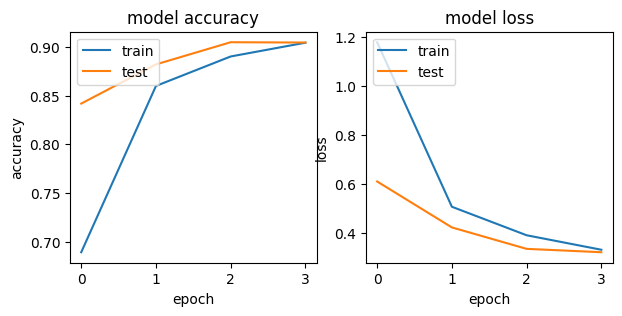

Accuracy  : 0.8926
Precision : 0.8974531772095022
Recall : 0.8926
f1Score : 0.893100074361045
[[ 954    0   11    2    3   12   22    9    8   16]
 [   0 1101    1    0    2    1    3   16    6    8]
 [   5    6  917   13    7   10   10   50   24    4]
 [   4   10   51  949    3   78    1   10   86   18]
 [   0    0   11    0  902   11    6    5   21   62]
 [  12    2    0   24    0  746   27    2   84   12]
 [   3    4   17    0   17    7  889    0   10    0]
 [   1    0    6   13    0    3    0  892   14   23]
 [   0   12   16    7    7   19    0    3  713    3]
 [   1    0    2    2   41    5    0   41    8  863]]
trained in server with 6000 examples


In [10]:
# 1. Train central model initially ----- (only 4 epochs)
deepModel = createDeepModel()
def trainInServer():
    h = deepModel.fit(xServer, yServer, 
                      epochs=4, batch_size=batch_size, verbose=verb,
                      validation_data=(xServerTest, yServerTest))
    deepModel.save(modelLocation)
    Analyze_training(h)
    yhat = deepModel.predict(xTest)
    y1 = np.argmax(yhat, axis=1)
    y2 = np.argmax(yTest, axis=1)
    my_metrics(y1,y2)
    print('trained in server with', len(xServer),'examples')
trainInServer()

In [11]:
# ------- 2. Separate clients data into lists ----------
xClientsList=[]
yClientsList=[]
clientsModelList=[]
clientDataInterval=len(xClients)//numOfClients
lastLowerBound=0

for clientID in range(numOfClients):
    xClientsList.append(xClients[lastLowerBound : lastLowerBound+clientDataInterval])
    yClientsList.append(yClients[lastLowerBound : lastLowerBound+clientDataInterval])
    model=load_model(modelLocation)
    clientsModelList.append(model)
    lastLowerBound+=clientDataInterval
yClientsList[1].shape

(10800, 10)

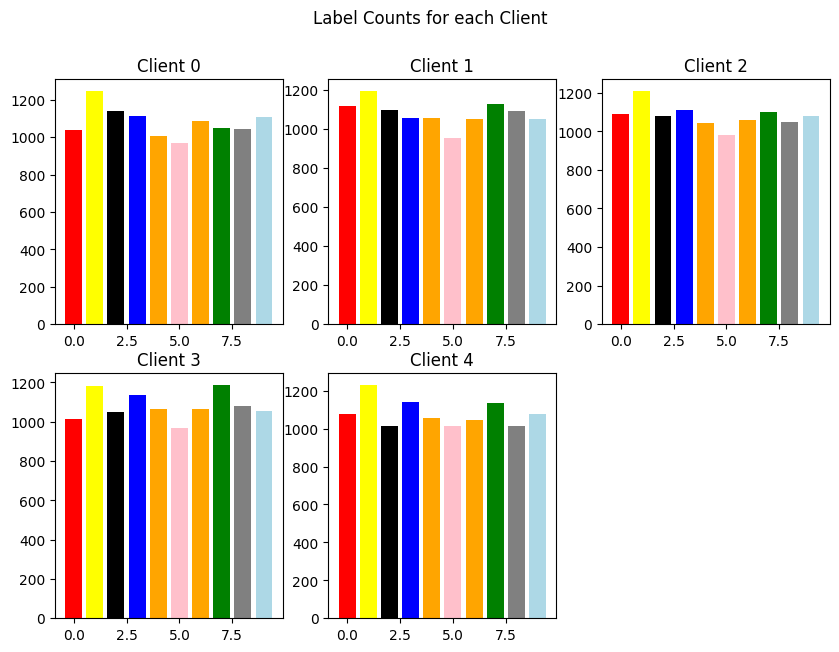

In [12]:
# visually check client distribution of data
# Number of examples per layer for a sample of clients

c = ['red', 'yellow', 'black', 'blue', 'orange', 'pink', 'orange', 'green', 'grey', 'lightblue']

f = plt.figure(figsize=(10,7))
f.suptitle('Label Counts for each Client')
b = np.arange(0, 10, 1)
for i in range(numOfClients):
    client_dataset = yClientsList[i]
    bin = client_dataset[0]
    for k in range(1,len(client_dataset)):
       bin = bin + client_dataset[k]
    np.squeeze(bin).shape
    f.add_subplot(2,3, i+1)
#    f.add_subplot(int(numOfClients/5), 5, i+1)
    plt.title('Client {}'.format(i))
    plt.bar(b,bin[b], color = c)
    
plt.show()   

In [13]:
# ------- 3. Update clients' model with intial server's deep-model ----------

#revisa si estas dos lineas valen
#for clientID in range(numOfClients):
#    clientsModelList[clientID].fit(xClientsList[clientID], yClientsList[clientID], epochs=epochs, batch_size=batch_size, verbose=verbose)
        
start_time = time.time()
process = psutil.Process(os.getpid())
for iterationNo in range(1,numOfIterations+1):
    print("Iteration",iterationNo)
    for clientID in range(numOfClients):
        print("clientID",clientID)
        clientsModelList[clientID].compile(loss='mean_squared_error', optimizer='adam', 
                                          metrics=['accuracy'])
        
        history = clientsModelList[clientID].fit(xClientsList[clientID], yClientsList[clientID], epochs=epochs, 
                                                 batch_size=batch_size, verbose=verb)
#        Analyze_training(history)
        clientWeight=clientsModelList[clientID].get_weights()
        # Find sum of all client's model
        updateServerModel(clientsModelList[clientID], clientWeight)
        firstClientFlag=False
        
    #Average all clients model
    
    for ind in range(len(deepModelAggWeights)):
        deepModelAggWeights[ind]/=numOfClients

    dw_last=deepModel.get_weights()

    for ind in range(len(deepModelAggWeights)): 
        dw_last[ind]=deepModelAggWeights[ind]
     
    #Update server's model
    deepModel.set_weights(dw_last) 
    print("Server's model updated")
    print("Saving model . . .")
    deepModel.save(modelLocation)
    # Servers model is updated, now it can be used again by the clients
    updateClientsModels()
    firstClientFlag=True
    deepModelAggWeights.clear()

    yPredict = deepModel.predict(xTest)
    acc, prec, recall, f1Score = predictTestData(yPredict, yTest)
    accList.append(acc)
    precList.append(prec)
    recallList.append(recall)
    f1List.append(f1Score)
    print("Acc:\n", acc)
    print("Prec:\n", prec)
    print("Recall:\n", recall)
    print("F1-Score:\n", f1Score)



Iteration 1
clientID 0
clientID 1
clientID 2
clientID 3
clientID 4
Server's model updated
Saving model . . .
yPredict 10000
Accuracy  : 0.9403
Precision : 0.9419055515876964
Recall : 0.9403
f1Score : 0.9403979876590063
[[ 965    0    0    2    0    1    2    1    7    2]
 [   0 1103    5    4    0    1    4    3   15    0]
 [  13    2  959   16    6    0    6    8   19    3]
 [   1    0   10  958    0    5    0    6   27    3]
 [   2    1    7    0  911    0   11    1    9   40]
 [   7    1    2   47    5  766   11    4   43    6]
 [  17    3    6    1    6   10  908    0    7    0]
 [   3    4   19   15    3    1    0  964    2   17]
 [   5    2    6   19    6    2    2    5  925    2]
 [  12    5    1    9   11    3    1    5   18  944]]
Acc:
 0.9403
Prec:
 0.9419055515876964
Recall:
 0.9403
F1-Score:
 0.9403979876590063
Iteration 2
clientID 0
clientID 1
clientID 2
clientID 3
clientID 4
Server's model updated
Saving model . . .
yPredict 10000
Accuracy  : 0.9472
Precision : 0.94883122

clientID 1
clientID 2
clientID 3
clientID 4
Server's model updated
Saving model . . .
yPredict 10000
Accuracy  : 0.9503
Precision : 0.9516549584161891
Recall : 0.9503
f1Score : 0.9504355865498192
[[ 967    0    2    3    0    2    2    0    4    0]
 [   0 1109    6    5    0    1    2    3    9    0]
 [   6    2  987   14    4    0    6    4    9    0]
 [   3    0    8  986    0    1    1    5    6    0]
 [   5    1    8    1  909    0    9    2    9   38]
 [   5    1    3   35    1  812   10    1   18    6]
 [   8    2    3    3    2   11  920    0    9    0]
 [   1    3   18   33    2    0    0  949    7   15]
 [   6    0    4   26    3    3    3    7  921    1]
 [   6    4    2   13    8    3    1    6   23  943]]
Acc:
 0.9503
Prec:
 0.9516549584161891
Recall:
 0.9503
F1-Score:
 0.9504355865498192
Iteration 12
clientID 0
clientID 1
clientID 2
clientID 3
clientID 4
Server's model updated
Saving model . . .
yPredict 10000
Accuracy  : 0.9501
Precision : 0.9512505217194567
Recall : 0.95

clientID 1
clientID 2
clientID 3
clientID 4
Server's model updated
Saving model . . .
yPredict 10000
Accuracy  : 0.9482
Precision : 0.949450349281817
Recall : 0.9482
f1Score : 0.948273323061506
[[ 969    0    2    3    0    2    1    0    2    1]
 [   0 1104    7    4    0    1    2    4   13    0]
 [  10    2  985   14    4    0    7    7    3    0]
 [   4    0    7  987    0    2    0    4    6    0]
 [   7    1    7    1  893    0    7    2   10   54]
 [   8    1    4   29    2  814    8    1   19    6]
 [  12    2    4    3    1   18  907    0   11    0]
 [   2    2   21   34    2    0    0  952    5   10]
 [   7    1    6   18    2    5    2    8  924    1]
 [   7    4    2   16    7    3    0    6   17  947]]
Acc:
 0.9482
Prec:
 0.949450349281817
Recall:
 0.9482
F1-Score:
 0.948273323061506
Iteration 22
clientID 0
clientID 1
clientID 2
clientID 3
clientID 4
Server's model updated
Saving model . . .
yPredict 10000
Accuracy  : 0.952
Precision : 0.9529932883445468
Recall : 0.952
f1S

---Memory--- 5.699634037844657
--- 622.3768842220306 seconds (TRAINING)---


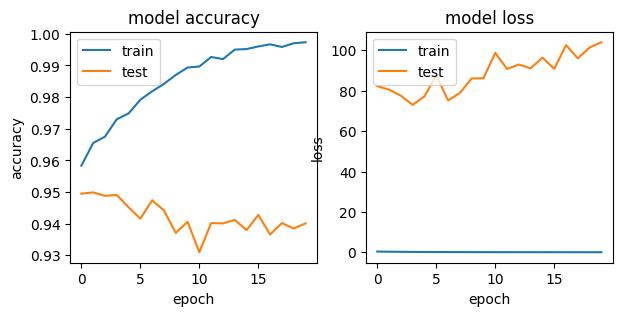

In [14]:
# 3. Evaluation at server

memoryTraining=process.memory_percent()
timeTraining=time.time() - start_time
print("---Memory---",memoryTraining)
print("--- %s seconds (TRAINING)---" % (timeTraining))

early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=verb, mode='auto')

history = deepModel.fit(xServer, yServer, epochs=epochs, 
                        validation_data = (xTest,yTest), verbose=verb)
                        # callbacks=[early_stopping])

learningAccs = history.history['val_accuracy']
learningLoss = history.history['val_loss']



Analyze_training(history)

In [15]:
# evaluation results
# resultSaveLocation=root_path+'Results/'+algoName+'_Users_vs_TR_vs_Iterations_vs_AccLossMemTime'+'.csv'
dfSave=pd.DataFrame(columns=['Clients', 'Iterations to converge', 'Accuracy', 'Loss', 'Memory', 'Time'])
dfSaveIndex=0
saveList = [numOfClients, len(learningLoss), learningAccs[len(learningAccs)-1], learningLoss[len(learningLoss)-1], memoryTraining, timeTraining]
dfSave.loc[dfSaveIndex] = saveList

yPredict = deepModel.predict(xTest)
acc, prec, recall, f1Score= predictTestData(yPredict, yTest)

print("Number of users:", numOfClients)
deepModel.save(modelLocation)

print("Iterations:", numOfIterations)
print("Memory:", memoryTraining)
print("Time:", timeTraining)
print(dfSave)

df_performance_timeRounds = pd.DataFrame(
    {'Accuracy': accList,
     'Precision': precList,
     'Recall': recallList,
     'F1-Score': f1List 
    })

yPredict 10000
Accuracy  : 0.9401
Precision : 0.9415325617189523
Recall : 0.9401
f1Score : 0.9401919871212431
[[ 957    0    7    3    1    2    1    2    4    3]
 [   0 1085   10    3    0    2    2    6   27    0]
 [   7    2  984    7    8    0   14    6    4    0]
 [   2    0    9  984    0    3    1    3    8    0]
 [   3    1    4    1  870    0   24    2   17   60]
 [   4    1    0   30    2  818   19    2   13    3]
 [  10    1    1    3    2    6  927    0    7    1]
 [   2    5   26   18    1    1    2  959    9    5]
 [   4    0   14   38    3   10   15    5  881    4]
 [   7    3    2   22    4    5    2    6   22  936]]
Number of users: 5
Iterations: 25
Memory: 5.699634037844657
Time: 622.3768842220306
   Clients  Iterations to converge  Accuracy        Loss    Memory        Time
0      5.0                    20.0    0.9401  104.044853  5.699634  622.376884


In [16]:
import session_info
session_info.show()

In [17]:
#EOF